In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


 **Aim:** This project aims to predict the sentiment of movie reviews using different machine learning models. I will be using the following models:
 * logistic regression
 * linear SVC, and 
 * multinomial naive Bayes.

# Loading Basic Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# **Data Loading**

In [3]:
train=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
test=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
movies=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')
sample=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv')

# **Feature Engineering**

> # Exploratory Data Analysis

> > # Understanding the Data and its features

In [31]:
print(train.head(2))
print('\n\n\n')
print(movies.head(2))

                                     movieid    reviewerName  \
0                           marvelous_pirate  Benjamin Henry   
1  tony_montana_frodo_baggins_v_rocky_balboa   Felicia Lopez   

   isFrequentReviewer                                         reviewText  \
0               False  Henry Selick’s first movie since 2009’s Corali...   
1               False  With a cast that reads like the Vogue Oscar pa...   

  sentiment  
0  POSITIVE  
1  NEGATIVE  




                                 movieid  \
0      han_solo_heroic_myth_wonder_woman   
1  voyage_tyler_durden_han_solo_stardust   

                                   title  audienceScore rating ratingContents  \
0      Han Solo Heroic Myth Wonder Woman           50.0    NaN            NaN   
1  Voyage Tyler Durden Han Solo Stardust            NaN    NaN            NaN   

  releaseDateTheaters releaseDateStreaming  runtimeMinutes  \
0                 NaN           2018-08-25            75.0   
1                 NaN          

In [32]:
print('Train shape:  ',train.shape,'\n')
print('Movies shape:  ',movies.shape,'\n')

print("Train info:",'\n')
print(train.info(),'\n')

print("Movies info:",'\n')
print(movies.info(),'\n')

#Train shape:   (162758, 5)
#Movies shape:   (143258, 14) 

Train shape:   (162758, 5) 

Movies shape:   (143258, 14) 

Train info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB
None 

Movies info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                1399

**Observation**

* The train data frame has 162758 rows and 5 columns, while the movies data frame has 143258 rows and 14 columns. 
* The train data frame has four object columns, one bool column, and no numeric columns. The object columns are movieid, reviewerName, reviewText, and sentiment. The **sentiment** is our TARGET variable.
* The movies data frame has 12 object columns, two numeric columns, and no bool columns.
* **releaseDateTheaters** Column and **releaseDateStreaming** are date columns but they are of object type by default.
* **boxOffice** column is the gross revenue of the movie in US dollars, is it of object type though it should be numeric, so we will work on these  columns.

 **Checking for and removing the duplicate values** before merging data frames to ensure that the resulting data frame is accurate and does not contain any redundant information.

In [33]:
print("Duplicates in Train:", train.duplicated().sum(),'\n')

print("Duplicates in Movies:", movies.duplicated().sum())

#Duplicates in Train: 1118 
#Duplicates in Movies: 1571

Duplicates in Train: 1118 

Duplicates in Movies: 1571


In [4]:
train  = train.drop_duplicates(keep='last')
movies = movies.drop_duplicates(keep='last')

#removing rows with duplicated values in the movieid column from the movies data frame,
#keeping only the last occurrence of each set of duplicated rows. 

movies = movies.drop_duplicates(subset =['movieid'],keep = 'last' )

**Renaming column**  isTopCritic as isFrequentReviewer to ensure that the column names are consistent across multiple data frames.

In [5]:
test.rename(columns={'isTopCritic':'isFrequentReviewer'},inplace=True)

**Data Integration**

In [12]:
df = pd.merge(train, movies, on='movieid', how='left')
test_df=pd.merge(test, movies, on='movieid', how='left')

In [37]:
#creating a new data frame that is a copy of the original data frame

data=df.copy()
test_data=test_df.copy()

# Quick Overview of the data

In [38]:
print(df.shape,'\n\n')
print(df.head(1),'\n\n')
print(df.info(),'\n]n')

(161640, 18) 


            movieid    reviewerName  isFrequentReviewer  \
0  marvelous_pirate  Benjamin Henry               False   

                                          reviewText sentiment  \
0  Henry Selick’s first movie since 2009’s Corali...  POSITIVE   

              title  audienceScore rating  \
0  Marvelous Pirate           65.0  PG-13   

                                      ratingContents releaseDateTheaters  \
0  ['Violence', 'Brief Strong Language', 'Substan...          2022-10-21   

  releaseDateStreaming  runtimeMinutes                                  genre  \
0           2022-10-28           105.0  Comedy, Animation, Adventure, Fantasy   

  originalLanguage      director boxOffice distributor soundType  
0          English  Bennie Basso       NaN     Netflix       NaN   


<class 'pandas.core.frame.DataFrame'>
Int64Index: 161640 entries, 0 to 161639
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------              

In [13]:
#converting our target variable from categorical to numerical 
df['sentiment'].replace({'POSITIVE':1,'NEGATIVE':0},inplace=True)

Converting the boxOffice **feature values from strings to numerical values** by removing the $ symbol, converting M to millions and K to thousands, and applying a custom function to the boxOffice column in both the df and test_df data frames. 

In [ ]:
df['boxOffice'] = df['boxOffice'].str.replace('$', '')
test_df['boxOffice'] = test_df['boxOffice'].str.replace('$', '')

def convert_box_office(amt):
    if 'M' in str(amt):
        return float(amt.replace("M",""))*1000000
    elif 'K' in str(amt):
        return float(amt.replace("K",""))*1000
    elif amt == np.nan:
        return amt
df['boxOffice'] = df['boxOffice'].apply(convert_box_office)
test_df['boxOffice'] = test_df['boxOffice'].apply(convert_box_office)

Converting **date columns to a datetime format** and renaming also.

In [15]:
df['RDT'] = pd.to_datetime(df['releaseDateTheaters'],errors='coerce')
df['RDS'] = pd.to_datetime(df['releaseDateStreaming'],errors='coerce')
df = df.drop(columns=['releaseDateTheaters', 'releaseDateStreaming'])

test_df['RDT'] = pd.to_datetime(test_df['releaseDateTheaters'],errors='coerce')
test_df['RDS'] = pd.to_datetime(test_df['releaseDateStreaming'],errors='coerce')
test_df = test_df.drop(columns=['releaseDateTheaters', 'releaseDateStreaming'])

In [ ]:
print("RDT:",df['RDT'].describe(),'\n\n')
print("RDS",df['RDS'].describe(),'\n\n')

Since the data contains dates ranging from year 1913 to the present, then there would be too many unique dates and months to consider. Therefore, **extracting the year from the release date columns** can help simplify the analysis by reducing the number of unique values to consider.

In [16]:
df['ryt'] = df['RDT'].dt.year
df['rys'] = df['RDS'].dt.year
test_df['ryt'] = test_df['RDT'].dt.year
test_df['rys'] = test_df['RDS'].dt.year

df = df.drop(['RDT','RDS'],axis=1)
test_df = test_df.drop(['RDT','RDS'],axis=1)

**Creating a stratified sample** of the df data frame because the df data frame is large, with a shape of (161640, 18), which means it has 161640 rows and 18 columns. Working with such a large dataset can be computationally expensive and time-consuming, especially when it comes to visualizing the data.

In [44]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['sentiment']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]


# Visualizations

Visualizing the **distribution of sentiment values** in the data 

1    108014
0     53626
Name: sentiment, dtype: int64


Text(0, 0.5, 'Count')

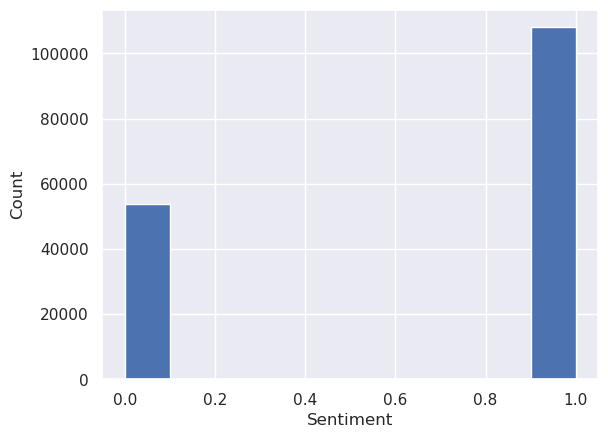

In [45]:
print(df.sentiment.value_counts())

sns.set()
df.sentiment.hist()
plt.xlabel('Sentiment')
plt.ylabel('Count')

In [46]:
#Printing first 3 reviews along their sentiments

for i in range(3):
    print("Review: ",[i])
    print(df['reviewText'].iloc[i],'\n')
    print('Sentiment:',df['sentiment'].iloc[i],'\n\n')

Review:  [0]
Henry Selick’s first movie since 2009’s Coraline. His fifth stop-motion masterpiece. 

Sentiment: 1 


Review:  [1]
With a cast that reads like the Vogue Oscar party guest list, Valentine's Day should have been can't-miss cinema instead of standard Hollywood schmaltz. 

Sentiment: 0 


Review:  [2]
Creed II does not give us anything but another, slightly superior Rocky sequel. It wins on points. Just don't expect a knockout. 

Sentiment: 1 




**Creating Pair plots** for exploring the relationships between variables in a dataset and for identifying patterns or correlations in the data.
By visualizing the pairwise relationships between variables, we can gain insights into the structure of the data and identify potential relationships that may be useful for further analysis or modeling.

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


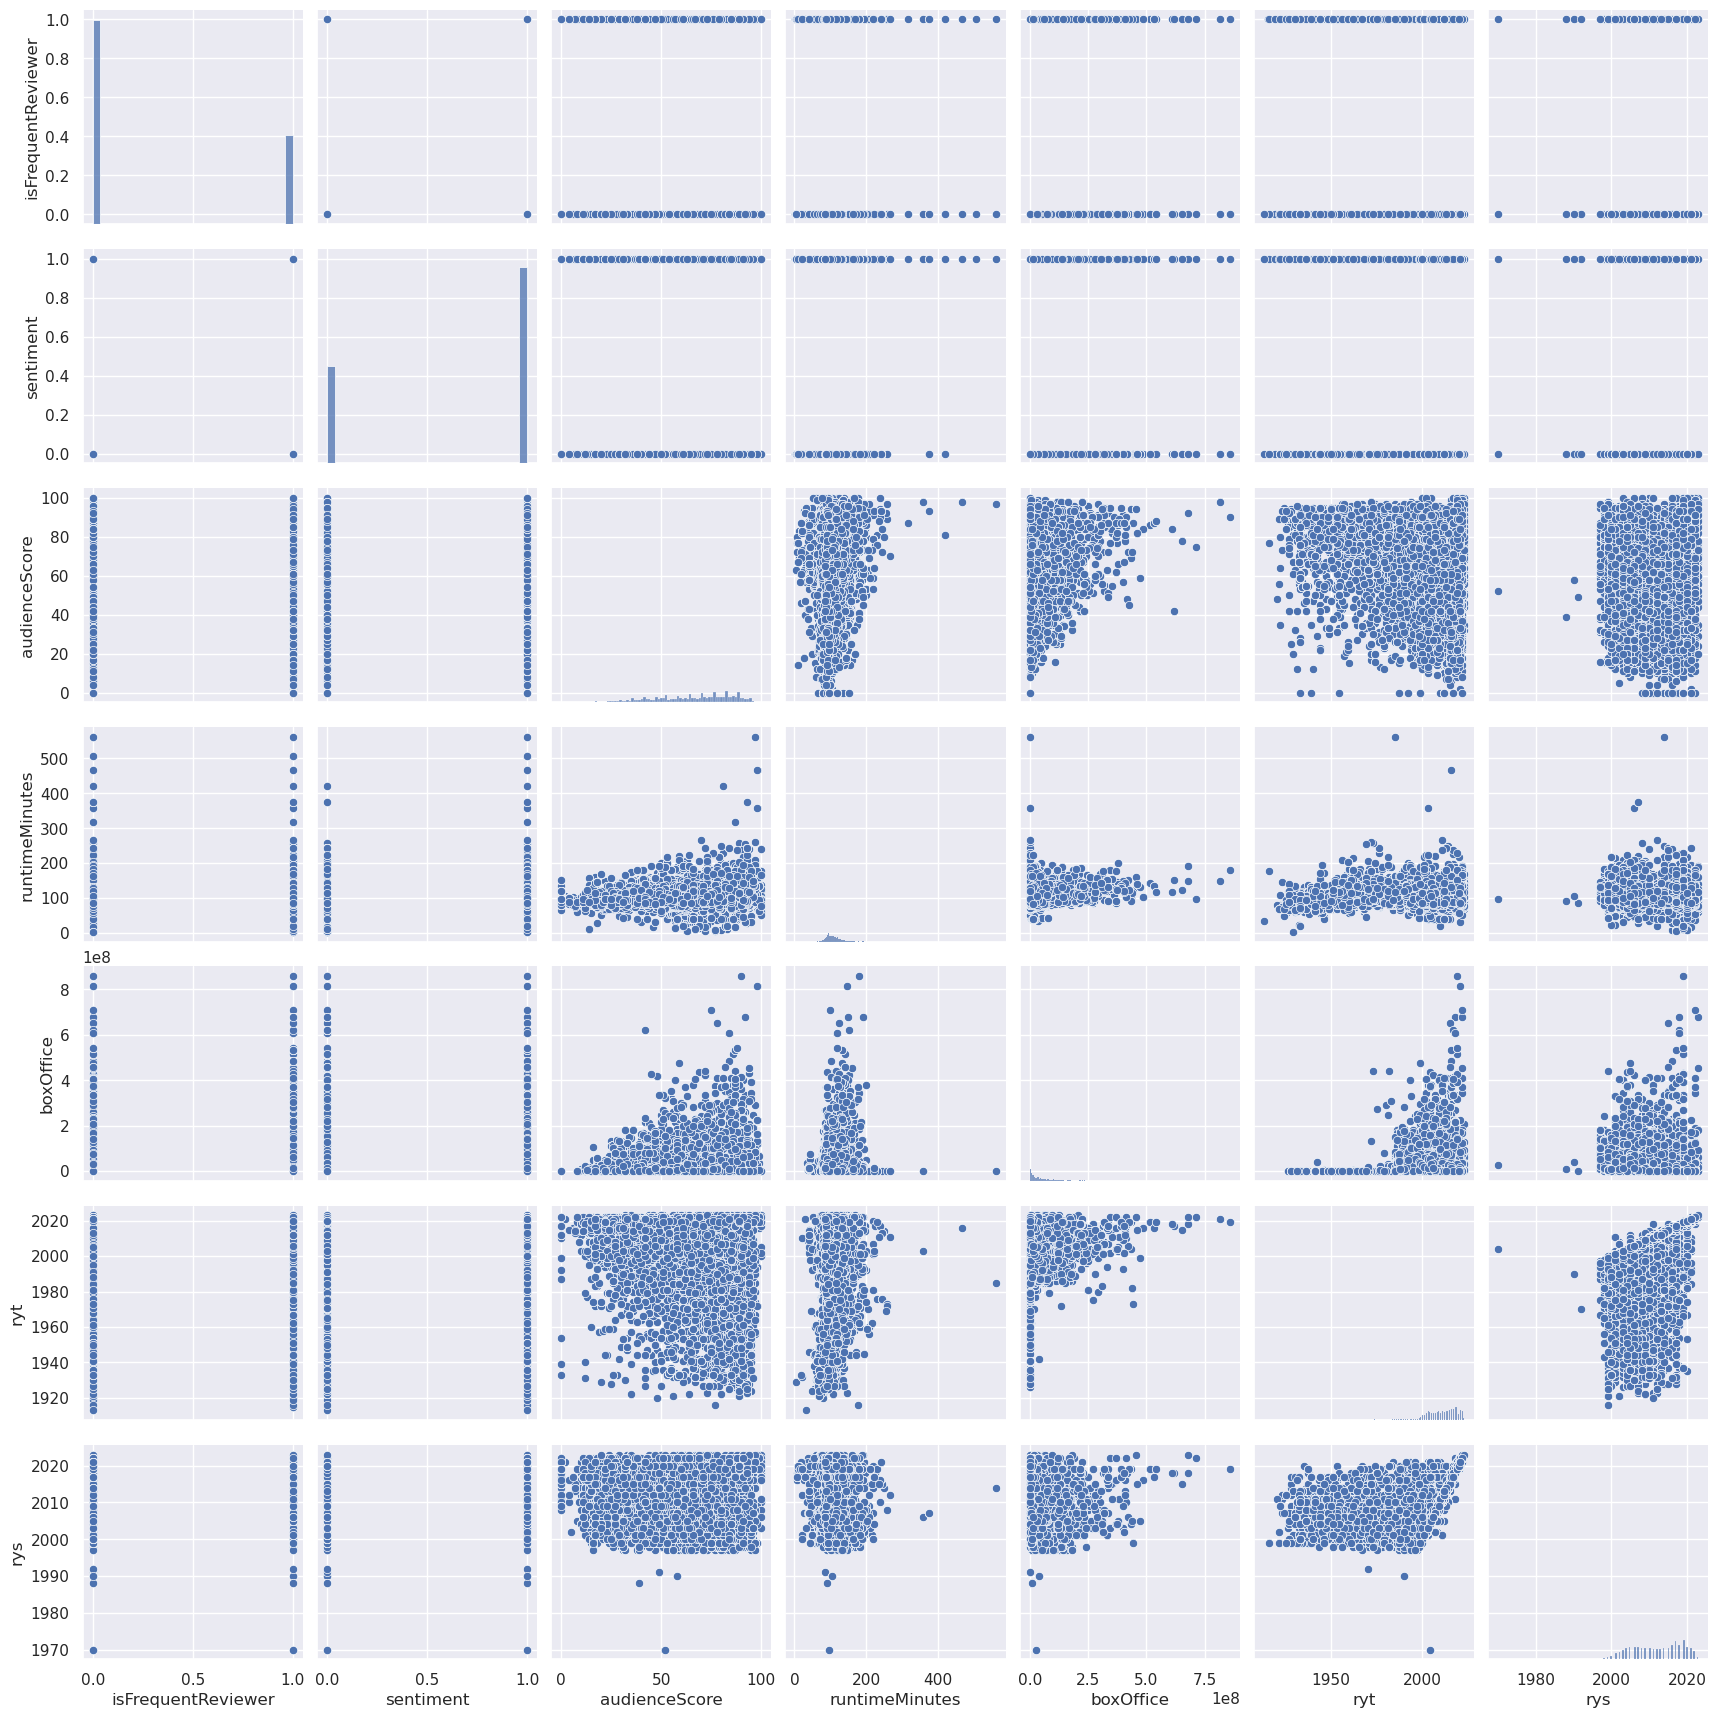

In [47]:
exploration_set = strat_train_set.copy()
sns.pairplot(exploration_set)

**Observation**

No strong positive trends can be seen between pair of variables.

Visualizing the **Percentage of Null Values Present** in Each Column.

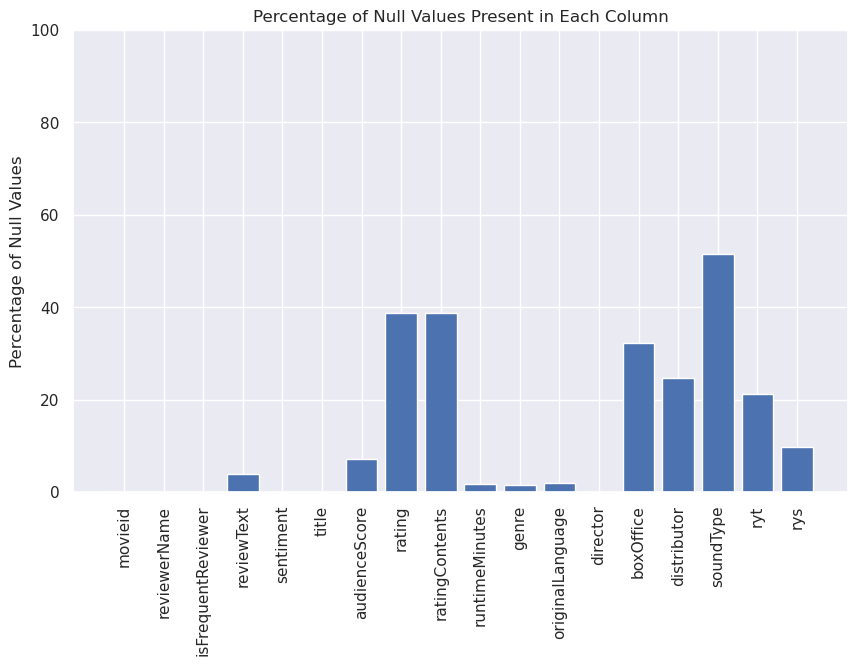

In [48]:
null_percentages = (df.isnull().sum()/len(df))*100

plt.figure(figsize=(10, 6))
plt.bar(null_percentages.index, null_percentages)
plt.xticks(rotation=90)
plt.ylabel('Percentage of Null Values')
plt.title('Percentage of Null Values Present in Each Column')
plt.ylim(0,100)
plt.show()

**Correlation matrix**

/tmp/ipykernel_32/1727630185.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


<Axes: >

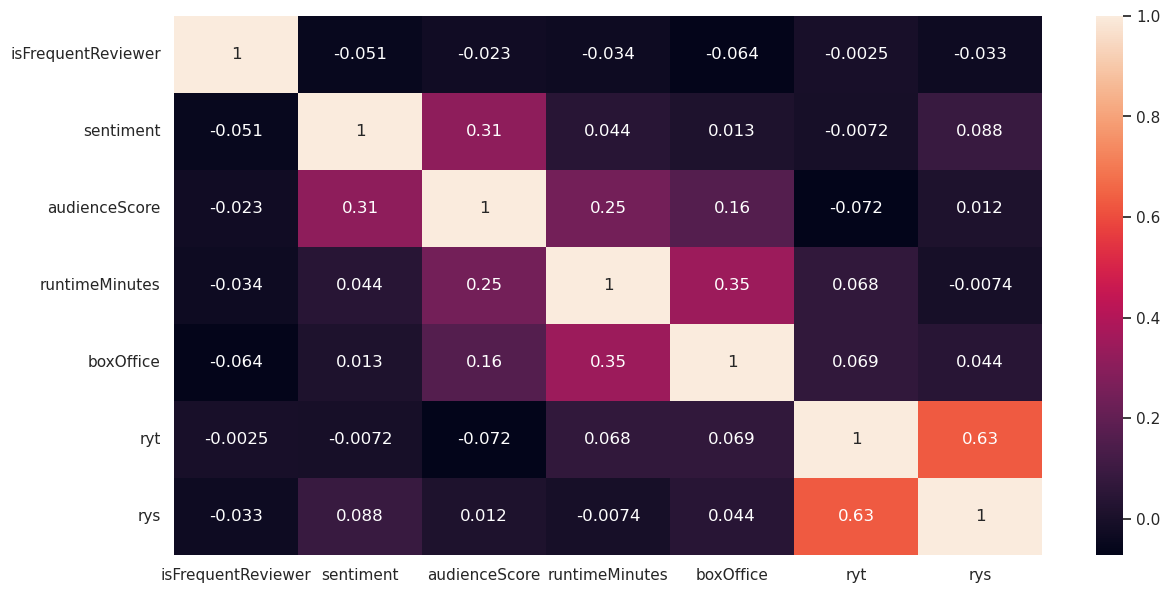

In [49]:
corr_matrix = df.corr()
plt.figure(figsize=(14,7))
sns.heatmap(corr_matrix, annot=True)

**Observations**
No strong positive correlations are found.
Very few weakly correlated features are present.

Dropping ryt "Release year theater" feature as they are highly correlated with rys,it means that they contain similar information and one of them might not be necessary for the prediction of the target variable. 
Whereas isFrequentReviewer shows negative correlation with all of the features in correlation matrix.Title column is redundant as it is same as movieid. Reviewer name may not be available or reliable for some reviews.Some reviewers may choose to remain anonymous or use fake names, or some reviews may not have any name associated with them at all. Whereas, SoundType has more than 50% missing values.


In [17]:
df = df.drop(['ryt','isFrequentReviewer','title','reviewerName','soundType'],axis=1)
test_df = test_df.drop(['ryt','isFrequentReviewer','title','reviewerName','soundType'],axis=1)

**Selecting numerical and categorial features** and creating a list of it.

In [18]:
numerical_features = df.select_dtypes(include=['float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print("num features:",numerical_features,'\n\n')
print("cat features:",categorical_features)


num features: ['audienceScore', 'runtimeMinutes', 'boxOffice', 'rys'] 


cat features: ['movieid', 'reviewText', 'rating', 'ratingContents', 'genre', 'originalLanguage', 'director', 'distributor']


**Visualizing the distribution of values for each numerical feature, grouped by sentiment**

Box plots can be useful for visualizing the relationship between a numerical variable and a categorical variable. By comparing the box plots for each sentiment group, we can see if there are any differences in the distribution of values for each numerical feature. This can help us identify potential relationships between the numerical features and the target variable.

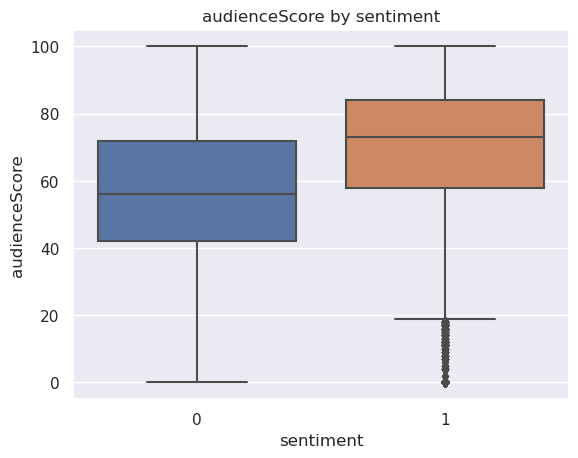

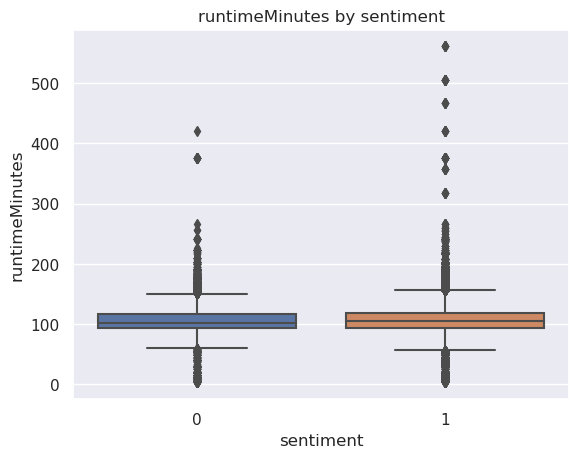

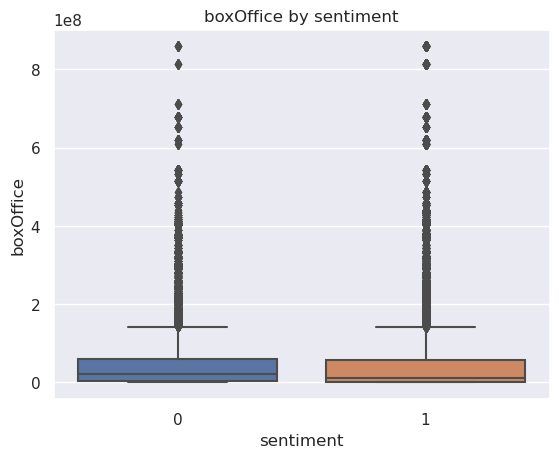

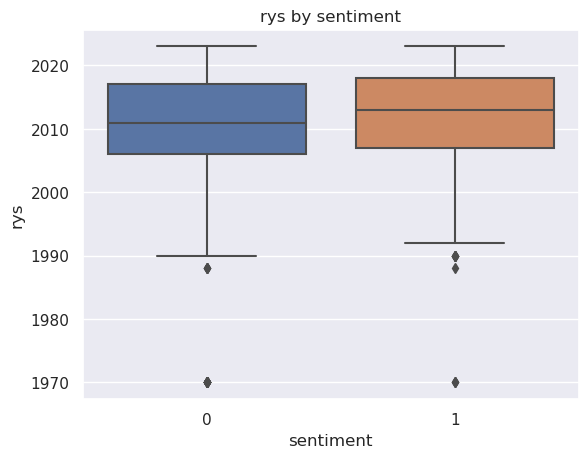

In [52]:
for feature in numerical_features:
    sns.boxplot(x='sentiment', y=feature, data=df)
    plt.title(feature + ' by sentiment')
    plt.show()

# Observations
 **Audience Score By Sentiment:** 
* The box plot shows that movies with a positive sentiment tend to have higher audience scores than movies with a negative sentiment.

* There is some overlap in the audience scores for the two sentiment groups, but there is also a clear difference in their distributions.

* There is also an outlier in the data, representing a movie with a positive sentiment but a low audience score.

**Runtime Minutes By Sentiment:**
* From the box plot, it can be concluded that the median runtimeMinutes for movies with sentiment 1 is higher than the median runtimeMinutes for movies with sentiment 0.
* This suggests that movies with sentiment 1 tend to have longer runtimeMinutes than movies with sentiment 0.

**Box Office Collection By Sentiment:**
* Presence of outliers suggests that for both sentiment 0 and 1 movies have unusually high box office collection.

**Year of movie Release in theater By Sentiment:**
* On average, movies with positive reviews are more recent than movies with negative reviews.
* Movies with positive reviews have less variation in their year of release than movies with negative reviews.

**Cardinality of categorical features**
Number of unique categories for each categorical feature in a DataFrame.

In [53]:
for feature in categorical_features:
  print('For feature {}  number of categories are {}'.format(feature,df[feature].nunique()),'\n')

For feature movieid  number of categories are 16812 

For feature reviewText  number of categories are 155071 

For feature rating  number of categories are 7 

For feature ratingContents  number of categories are 4518 

For feature genre  number of categories are 1158 

For feature originalLanguage  number of categories are 90 

For feature director  number of categories are 9478 

For feature distributor  number of categories are 1623 



Visualizing the **distribution of word counts per review**. 

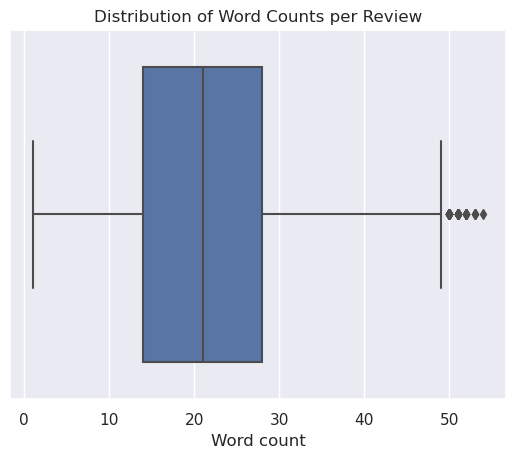

In [54]:
def no_of_words(text):
    words=str(text).split()
    word_count=len(words)
    return word_count
no_of_words=df['reviewText'].apply(no_of_words)

sns.boxplot(x=no_of_words)
plt.xlabel('Word count')
plt.title('Distribution of Word Counts per Review')
plt.show()

**Observation**
* The median word count per review is around 20, which means that half of the reviews have more than 20 words and half of the reviews have less than 20 words.
* The lower quartile is around 15 and the upper quartile is around 30, which means that 50% of the reviews have between 15 and 30 words. 
* There are 5 outliers above the maximum value, which are represented by black dots. These are reviews that have more than almost 50 words, which are unusually long compared to the rest of the reviews. 

# **Preparing the Data for ML Algorithms**

**Feature processing (scaling and encoding)**

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler


Splitting the our data into training and validation sets.

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['sentiment']):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

X_train = train_set.drop('sentiment',axis=1)
Y_train = train_set['sentiment']
X_test = test_set.drop('sentiment',axis=1)
Y_test = test_set['sentiment']

**BEFORE Processing numerical features**

In [57]:
X_train[numerical_features].describe()

,audienceScore,runtimeMinutes,boxOffice,rys
count,120029.000000,127000.000000,8.755800e+04,116727.000000
mean,65.037491,106.850835,4.952471e+07,2012.037472
std,19.814032,22.370186,8.801892e+07,6.457617
min,0.000000,3.000000,1.000000e+03,1970.000000
25%,51.000000,93.000000,9.776000e+05,2007.000000
50%,68.000000,104.000000,1.510000e+07,2013.000000
75%,81.000000,118.000000,5.820000e+07,2018.000000
max,100.000000,561.000000,8.584000e+08,2023.000000


In [58]:
print("Shape of X_train before any scaling and encoding: ", X_train.shape,'\n')
print("Shape of X_test before any scaling and encoding: ", X_test.shape,'\n')
print("Shape of test_df before any scaling and encoding: ", test_df.shape,'\n')

Shape of X_train before any scaling and encoding:  (129312, 12) 

Shape of X_test before any scaling and encoding:  (32328, 12) 

Shape of test_df before any scaling and encoding:  (55315, 12) 



**Handling Missing values/scaling Numerical Features**

> **Detecting Missing values**

In [59]:
for feature in numerical_features:
  print('{}: {}% missing values'.format(feature,np.round(df[feature].isnull().mean()*100,3)))

audienceScore: 7.199% missing values
runtimeMinutes: 1.755% missing values
boxOffice: 32.271% missing values
rys: 9.774% missing values


> **Imputing and scaling our numerical features**

In [21]:
num_pipe = Pipeline([ ('imputer', SimpleImputer(strategy='median')), 
                      ('scaler', MinMaxScaler()) ])

X_train[numerical_features]=num_pipe.fit_transform(X_train[numerical_features])
X_test[numerical_features]=num_pipe.transform(X_test[numerical_features])
test_df[numerical_features]=num_pipe.transform(test_df[numerical_features])

In [61]:
for feature in numerical_features:
  print('After imputation missing values in {}: {}% '.format(feature,np.round(X_train[feature].isnull().mean()*100,3)))

After imputation missing values in audienceScore: 0.0% 
After imputation missing values in runtimeMinutes: 0.0% 
After imputation missing values in boxOffice: 0.0% 
After imputation missing values in rys: 0.0% 


**AFTER processing numerical features**

In [62]:
X_train[numerical_features].describe()

,audienceScore,runtimeMinutes,boxOffice,rys
count,129312.000000,129312.000000,129312.000000,129312.000000
mean,0.652502,0.186021,0.044744,0.794927
std,0.191049,0.039736,0.086434,0.115886
min,0.000000,0.000000,0.000000,0.000000
25%,0.520000,0.163082,0.005125,0.698113
50%,0.680000,0.181004,0.017590,0.811321
75%,0.800000,0.206093,0.038210,0.886792
max,1.000000,1.000000,1.000000,1.000000


**Handling Missing values/encoding Catagorical Features**

> 

> **Detecting Missing values**

In [63]:
for feature in categorical_features:
  print('{}: {}% missing values'.format(feature,np.round(df[feature].isnull().mean()*100,3)))

movieid: 0.0% missing values
reviewText: 3.958% missing values
rating: 38.804% missing values
ratingContents: 38.804% missing values
genre: 1.465% missing values
originalLanguage: 2.055% missing values
director: 0.0% missing values
distributor: 24.592% missing values


> **Filling na with empty string**

Creating a **SimpleImputer** object to impute missing values in the categorical features of the training, validation, and test datasets. The SimpleImputer is set to use a constant fill value of an empty string.

In [22]:
si = SimpleImputer(strategy='constant', fill_value='')

X_train[categorical_features]=si.fit_transform(X_train[categorical_features])
X_test[categorical_features]=si.transform(X_test[categorical_features])
test_df[categorical_features]=si.transform(test_df[categorical_features])

> **Encoding categorical features**

A **ColumnTransformer** is then created using the list of encoders and is applied to the training, validation, and test datasets to transform the categorical features into numerical representations.

In [23]:
Encoder = [("ohe1",OneHotEncoder(handle_unknown='ignore',sparse_output = False), ['distributor']),
           ("c_vect1",CountVectorizer(),'movieid'),
           ("c_vect2",CountVectorizer(),'originalLanguage'),
           ("c_vect3",CountVectorizer(),'director'),
           ("ord1",OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=np.nan),['rating']),
           ("t_vect1", TfidfVectorizer(ngram_range=(1,2)),'reviewText'),
           ("t_vect2", TfidfVectorizer(ngram_range=(1,2)),'ratingContents'),
           ("t_vect3", TfidfVectorizer(ngram_range=(1,2)),'genre')
          ]

ct = ColumnTransformer(Encoder, remainder='passthrough')     

In [24]:
X_train=ct.fit_transform(X_train)
X_test=ct.transform(X_test)
test_df=ct.transform(test_df)

In [67]:
print("Shape of X_train after scaling and encoding of categorical features: ", X_train.shape,'\n')
print("Shape of X_test after scaling and encoding of categorical features: ", X_test.shape,'\n')
print("Shape of test_df after scaling and encoding of categorical features: ", test_df.shape,'\n')

#Shape of X_train after scaling and encoding of categorical features:  (129312, 961531) 
#Shape of X_test after scaling and encoding of categorical features:  (32328, 961531) 
#Shape of test_df after scaling and encoding of categorical features:  (55315, 961531) 

Shape of X_train after scaling and encoding of categorical features:  (129312, 961531) 

Shape of X_test after scaling and encoding of categorical features:  (32328, 961531) 

Shape of test_df after scaling and encoding of categorical features:  (55315, 961531) 



# **Training Model**

> # **0. Baseline Model**

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [69]:
from sklearn.dummy import DummyClassifier

dc = DummyClassifier(strategy='most_frequent')
dc.fit(X_train,Y_train)

pred_dc = dc.predict(X_test)

score_dc = f1_score(Y_test,dc.predict(X_test), average='micro')

print(score_dc)
#0.6682442464736451

0.6682442464736451


> # **1a. Logistic Regression**(without HPT)

> > * Creating a **LogisticRegression** object.
> > * Performed cross-validation for the logistic regression object on on the training data using cross_val_score with 5-fold cross-validation. 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(solver='saga',max_iter=1000)
lr.fit(X_train, Y_train)

y_pred = lr.predict(X_test)

f1_micro = f1_score(Y_test,lr.predict(X_test), average='micro')
print('F1 micro score:', f1_micro)

cv_scores = cross_val_score(lr, X_train, Y_train, cv=5, scoring='f1_micro')

print('Cross validation scores:', cv_scores)

#F1 micro score: 0.8234038604305864
#Cross validation scores: [0.81738391 0.81742257 0.81517284 0.81849818 0.81656484]

> # **1b. Logistic Regression**(with HPT)

> > * Creating a **LogisticRegression** object and defining a parameter grid to specify the hyperparameters to be tuned. 
> > * A **GridSearchCV** object is then created to perform **hyperparameter tuning** using grid search with 5-fold cross-validation. 
> > * The GridSearchCV object is fitted to the training data and the best hyperparameters are obtained.

In [ ]:

# Defining the parameter grid to search over
param_grid = {'penalty':['l1','l2'],
              'C': [1,10]
              
             }
#Creating an instance of GridSearchCV with logistic regression as the estimator
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='f1_micro')

 #Fit the grid search on the training data
grid_search.fit(X_train, Y_train)

print('Best parameters:', grid_search.best_params_)

#Best parameters: {'C': 10, 'penalty': 'l2'}

In [ ]:
lr2 = LogisticRegression(C= 10,penalty='l2',solver='saga',max_iter=1000) #using best parameters

lr2.fit(X_train, Y_train)

y_pred = lr2.predict(X_test)

f1_micro_lr = f1_score(Y_test,lr2.predict(X_test), average='micro')

print(f"Logistic Regression model F1 score (micro) using best parameters : {f1_micro_lr}")


#Logistic Regression model F1 score (micro) using best parameters : 0.8302400395941598

> # **2. SVM Model**

> > # **2a. Linear SVC** (Without HPT)

In [ ]:
from sklearn.svm import LinearSVC

lsvc = LinearSVC()
lsvc.fit(X_train, Y_train)

Y_pred_svc = lsvc.predict(X_test)

score_svc = f1_score(Y_test,lsvc.predict(X_test) , average='micro')

print(score_svc)

#0.8292501855976243

> > # **2b. Linear SVC** (With HPT)

In [ ]:
# Defining the hyperparameters to tune
params = {
    'C': [ 1.0, 10.0], # The regularization parameter
    'max_iter': [1000, 3000] # The maximum number of iterations
}

# Creating a LinearSVC object
lsvc = LinearSVC(random_state=42)

# Creating a GridSearchCV object to perform hyperparameter tuning
grid = GridSearchCV(lsvc, params, cv=5, scoring ='f1_micro')

# Fitting the grid on the training data
grid.fit(X_train, Y_train)

# Printing the best parameters and score
print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

#Best parameters: {'C': 1.0, 'max_iter': 1000}
#Best score: 0.8229089261924816


In [ ]:
lsvc2=LinearSVC(C=1, max_iter=1000)
lsvc2.fit(X_train,Y_train)

Y_pred_svc2 = lsvc.predict(X_test)

score_svc2 = f1_score(Y_test,lsvc2.predict(X_test) , average='micro')

print(score_svc2)

#0.8292501855976243 score using best parameters

> # **3. Naive Bayes Model**

> > # **3a. MultinomialNB** (Without HPT)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train, Y_train)

y_pred_mnb=mnb.predict(X_test)

score_mnb=f1_score(Y_test,mnb.predict(X_test), average='micro')

print(score_mnb)

#0.7160975006186587

> > # **3b. MultinomialNB** (With HPT)

In [ ]:
# Defining the hyperparameters to tune
params = {
    'alpha': [0.01, 0.1, 1.0, 10.0], # The smoothing parameter
    'fit_prior': [True, False] # Whether to learn class prior probabilities or not   
}

# Creating a GridSearchCV object to perform hyperparameter tuning
grid = GridSearchCV(mnb, params, cv=5, scoring='f1_micro', verbose=1,error_score='raise')

# Fitting the grid on the data
grid.fit(X_train, Y_train)

# Print the best parameters and score
print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

#Best parameters: {'alpha': 0.1, 'fit_prior': True}
#Best score: 0.7734703371007055

In [ ]:
mnb2=MultinomialNB(alpha= 0.1,fit_prior= True)
mnb2.fit(X_train, Y_train)
y_pred_mnb2=mnb2.predict(X_test)
score_mnb2=f1_score(Y_test,mnb2.predict(X_test), average='micro')
print(score_mnb2)

#0.7869339272457313 score using best parameters

# **Loss Function**

The loss function for logistic regression is a measure of how well the model fits the data. It is also known as the log loss, logistic loss, or cross-entropy loss. The loss function is defined as the negative log-likelihood of a logistic model that returns the predicted probabilities for the true labels of the data.

Calculated log loss for each model below and got the following results.

In [ ]:
from sklearn.metrics import log_loss

In [ ]:

# Getting the predicted probabilities for the test set
y_pred_prob = lr.predict_proba(X_test)

# Calculating and printing the log loss
loss = log_loss(Y_test, y_pred_prob)
print("Log loss:", loss)

#Log loss: 0.3877430829148136

In [ ]:
# Getting the predicted probabilities for the test set
y_pred_prob = lr2.predict_proba(X_test)

# Calculating and printing the log loss
loss = log_loss(Y_test, y_pred_prob)
print("Log loss:", loss)

#Log loss: 0.39364482236669224

In [ ]:
# Getting the predicted probabilities for the test set
y_pred_prob = mnb.predict_proba(X_test)

# Calculating and printing the log loss
loss = log_loss(Y_test, y_pred_prob)
print("Log loss:", loss)

#Log loss: 1.1209131080071555

In [ ]:
# Getting the predicted probabilities for the test set
y_pred_prob = mnb2.predict_proba(X_test)

# Calculating and printing the log loss
loss = log_loss(Y_test, y_pred_prob)
print("Log loss:", loss)

#Log loss: 0.6745528503186061

In [ ]:
# Get the decision function values for the test set
y_pred_prob =lsvc.decision_function(X_test)

# Calculate and print the log loss
loss = log_loss(Y_test, y_pred_prob)
print("Log loss:", loss)

#Log loss: 3.257502556809884

In [ ]:
# Get the decision function values for the test set
y_pred_prob =lsvc2.decision_function(X_test)

# Calculate and print the log loss
loss = log_loss(Y_test, y_pred_prob)
print("Log loss:", loss)

#Log loss: 3.257502617536324

* For Logistic Regression model without HPT
> Log loss: **0.3877430829148136**
* For Logistic Regression model with HPT
> Log loss: **0.39364482236669224**
* For Linear SVC model without HPT
> Log loss: **3.257502556809884**
* For Linear SVC model with HPT
> Log loss: **3.257502617536324**
* For MultinomialNB model without HPT
> Log loss: **1.1209131080071555**
* For MultinomialNB model with HPT
> Log loss: **0.6745528503186061**


# **Inference**

**Evaluation Metric:** 
> * I have used the F1 micro score as the evaluation metric, which is the harmonic mean of precision and recall for each class, weighted by the number of instances in each class. This metric is suitable for imbalanced classification problems, where some classes have more instances than others.
> * I have also used the log loss as another evaluation metric, which is the negative log-probability of the true labels given the predictions. This metric is suitable for probabilistic models, where the predictions are not binary but continuous between 0 and 1. The lower the log loss, the better the model fits the data.

* I have compared the performance of different models with and without hyperparameter tuning (HPT), which is a process of finding the optimal values for the parameters that control the behavior and complexity of the models. 
* I have used grid search as a method of HPT, which is a technique that exhaustively searches over a predefined set of values for each parameter.

> **Based on the results, I can infer that:**
> * **Logistic regression** is the best performing model among all, with or without HPT. It has the highest F1 micro score and the lowest log loss among all models. This means that logistic regression is able to accurately predict the sentiment of movie reviews and assign high probabilities to the correct labels. "Logistic regression is a linear model that assumes that there is a linear relationship between the features and the log-odds of the outcome. It also uses regularization to prevent overfitting and improve generalization."

> * **Linear SVC** is the second best performing model among all, with or without HPT. It has a slightly lower F1 micro score than logistic regression, but a much higher log loss. This means that linear SVC is able to accurately predict the sentiment of movie reviews, but not assign high probabilities to the correct labels. "Linear SVC is a linear model that uses a hinge loss function and a margin-based optimization technique to separate the classes. It also uses regularization to prevent overfitting and improve generalization."

> * **Multinomial naive Bayes** is the worst performing model among all, with or without HPT. It has the lowest F1 micro score and the highest log loss among all models. This means that multinomial naive Bayes is not able to accurately predict the sentiment of movie reviews or assign high probabilities to the correct labels. "Multinomial naive Bayes is a probabilistic model that uses a multinomial distribution to model the frequency of words in each class. It also uses a strong assumption of conditional independence between features, which may not hold true in reality."

> * HPT improves the performance of all models, except for linear SVC. For logistic regression and multinomial naive Bayes, HPT increases their F1 micro scores and decreases their log losses. For linear SVC, HPT does not change its F1 micro score or its log loss. This means that HPT helps to find better values for some parameters that affect the models’ performance, such as regularization strength, smoothing factor, etc. However, for linear SVC, HPT does not find any significant improvement over its default values.

In [30]:
# Making predictions on the test set using Best Model
prediction = lr2.predict(test_df)

print("Prediction on test set:", prediction)

Prediction on test set: [1 1 1 ... 0 1 0]


Classifying the predictions as POSITIVE and NEGATIVE

In [31]:
y_label = []
for pred in prediction:
    if pred >= 0.5:
        y_label.append('POSITIVE')
    else:
        y_label.append('NEGATIVE')

In [32]:
#using original test data making id column corresponding to each predicted sentiment 
#test['reviewText']

id = []
for i in range(len(test['reviewText'])):
    id.append(i)

test['id'] = pd.Series(id)

**Making submission csv according to given sample csv.**

In [33]:
submission_df = pd.DataFrame({'id': test['id'], 'sentiment': y_label})

submission_df.to_csv('submission.csv', index=False)


f1_micro = f1_score(Y_test, lr2.predict(X_test), average='micro')
print(f"F1 score (micro): {f1_micro}")

#F1 score (micro): 0.8302400395941598

F1 score (micro): 0.8302400395941598


**Best Model is Logistic Regression**
**F1 score (micro): 0.8302400395941598**

# ThankYou